<a href="https://colab.research.google.com/github/OJB-Quantum/Cool-Mesh-Files/blob/main/Google%20Colab%20Notebooks/SVG_PNG_to_GEO_Mesh_Conversion_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

In [ ]:
# Colab cell: install dependencies
!pip -q install cairosvg opencv-python-headless pillow numpy

In [ ]:
# Colab cell: imports + configuration

from __future__ import annotations

import io
import os
from dataclasses import dataclass
from typing import Dict, List, Optional, Sequence, Tuple

import numpy as np
from PIL import Image

plt.rcParams['figure.dpi'] = 200

# OpenCV is used only for contour extraction + simplification
import cv2

# CairoSVG is used to rasterize SVG into RGBA, so SVG and PNG share the same pipeline
import cairosvg


@dataclass(frozen=True)
class MeshConfig:
    """Configuration for image-to-Gmsh-geo conversion (millimeter-native).

    Attributes:
      target_width_mm: Desired total horizontal extent (width) of the design in mm.
      make_3d: If True, add an Extrude block to generate 3D volume(s).
      thickness_mm: Z extrusion thickness in mm (used when make_3d=True).
      extrude_layers: Number of element layers through thickness (integer >= 1).

      raster_width_px: For SVG, render to this pixel width before contouring.
      alpha_threshold: Alpha cutoff in [0..255] for foreground detection.
      morph_close_px: If > 0, apply morphological closing with this kernel size.

      simplify_epsilon_mm: Douglas–Peucker tolerance in mm (0 disables).
      min_area_mm2: Drop contours smaller than this area in mm^2.

      edge_size_min_mm: Near-edge element size (Threshold.SizeMin).
      edge_size_max_mm: Far-from-edge element size (Threshold.SizeMax).
      edge_dist_min_mm: Distance where near-edge sizing begins.
      edge_dist_max_mm: Distance where far sizing is reached.
      distance_sampling: Sampling resolution used by Gmsh Distance field.

      enable_boundary_layer_2d: If True, additionally emit a 2D BoundaryLayer field
        (primarily useful for CFD when meshing in 2D, then extruding). Note: Gmsh’s
        BoundaryLayer field is documented as working in 2D. :contentReference[oaicite:3]{index=3}
      bl_size_mm: First-layer-ish normal size parameter (Field[BoundaryLayer].Size).
      bl_ratio: Growth ratio (Field[BoundaryLayer].Ratio).
      bl_thickness_mm: Total boundary layer thickness (Field[BoundaryLayer].Thickness).
      bl_n_layers: Number of layers (Field[BoundaryLayer].NbLayers).
      bl_quads: If 1, request recombined quads in boundary layer (Field[BoundaryLayer].Quads).
    """

    # Geometry scaling + dimensionality
    target_width_mm: float = 1.0
    make_3d: bool = False
    thickness_mm: float = 0.05
    extrude_layers: int = 1

    # SVG rasterization / mask extraction
    raster_width_px: int = 4000
    alpha_threshold: int = 12
    morph_close_px: int = 0

    # Polygon simplification and filtering
    simplify_epsilon_mm: float = 0.0
    min_area_mm2: float = 0.0

    # Edge-refined mesh sizing (Distance + Threshold)
    edge_size_min_mm: float = 1.0 / 300.0
    edge_size_max_mm: float = 1.0 / 80.0
    edge_dist_min_mm: float = 1.0 / 250.0
    edge_dist_max_mm: float = 1.0 / 40.0
    distance_sampling: int = 150

    # Optional 2D boundary layer (CFD-ish)
    enable_boundary_layer_2d: bool = False
    bl_size_mm: float = 1.0 / 800.0
    bl_ratio: float = 1.2
    bl_thickness_mm: float = 1.0 / 80.0
    bl_n_layers: int = 10
    bl_quads: int = 1


APPLICATION_PRESETS: Dict[str, MeshConfig] = {
    # Electrostatics: fields can spike at edges/corners; keep near-edge sizing tight.
    "electrostatics": MeshConfig(
        edge_size_min_mm=1.0 / 400.0,
        edge_size_max_mm=1.0 / 70.0,
        edge_dist_min_mm=1.0 / 300.0,
        edge_dist_max_mm=1.0 / 35.0,
    ),
    # Thermal: gradients exist at boundaries and sources, but are often smoother than E-fields.
    "thermal": MeshConfig(
        edge_size_min_mm=1.0 / 280.0,
        edge_size_max_mm=1.0 / 60.0,
        edge_dist_min_mm=1.0 / 220.0,
        edge_dist_max_mm=1.0 / 30.0,
    ),
    # Mechanics: stress concentration near corners/fillets; similar needs as electrostatics.
    "mechanics": MeshConfig(
        edge_size_min_mm=1.0 / 350.0,
        edge_size_max_mm=1.0 / 70.0,
        edge_dist_min_mm=1.0 / 250.0,
        edge_dist_max_mm=1.0 / 35.0,
    ),
    # CFD (2D then extrude): consider boundary layer field in 2D, then extrude prisms.
    "cfd_2d_extrude": MeshConfig(
        make_3d=True,
        thickness_mm=0.10,
        extrude_layers=2,
        edge_size_min_mm=1.0 / 500.0,
        edge_size_max_mm=1.0 / 60.0,
        edge_dist_min_mm=1.0 / 350.0,
        edge_dist_max_mm=1.0 / 25.0,
        enable_boundary_layer_2d=True,
        bl_size_mm=1.0 / 1200.0,
        bl_ratio=1.25,
        bl_thickness_mm=1.0 / 60.0,
        bl_n_layers=12,
        bl_quads=1,
    ),
    # Lithography-ish (mask features): depends strongly on smallest feature and wavelength models.
    "lithography_mask": MeshConfig(
        edge_size_min_mm=1.0 / 600.0,
        edge_size_max_mm=1.0 / 90.0,
        edge_dist_min_mm=1.0 / 450.0,
        edge_dist_max_mm=1.0 / 45.0,
        simplify_epsilon_mm=0.0,
    ),
}

# -------------------------
# Choose your configuration
# -------------------------
APPLICATION = "electrostatics"  # Change to one of: electrostatics, thermal, mechanics, cfd_2d_extrude, lithography_mask
CFG = APPLICATION_PRESETS[APPLICATION]

print("Using application preset:", APPLICATION)
print(CFG)


Using application preset: electrostatics
MeshConfig(target_width_mm=1.0, make_3d=False, thickness_mm=0.05, extrude_layers=1, raster_width_px=4000, alpha_threshold=12, morph_close_px=0, simplify_epsilon_mm=0.0, min_area_mm2=0.0, edge_size_min_mm=0.0025, edge_size_max_mm=0.014285714285714285, edge_dist_min_mm=0.0033333333333333335, edge_dist_max_mm=0.02857142857142857, distance_sampling=150, enable_boundary_layer_2d=False, bl_size_mm=0.00125, bl_ratio=1.2, bl_thickness_mm=0.0125, bl_n_layers=10, bl_quads=1)


In [ ]:
# Colab cell: upload a single file
from google.colab import files  # pylint: disable=import-error

uploaded = files.upload()
if not uploaded:
    raise RuntimeError("No file uploaded.")

input_name = next(iter(uploaded.keys()))
input_path = os.path.join("/content", input_name)

with open(input_path, "wb") as f:
    f.write(uploaded[input_name])

print("Uploaded:", input_path)


Saving IBM_logo.svg to IBM_logo.svg
Uploaded: /content/IBM_logo.svg


RGBA image size (px): (4000, 1493)


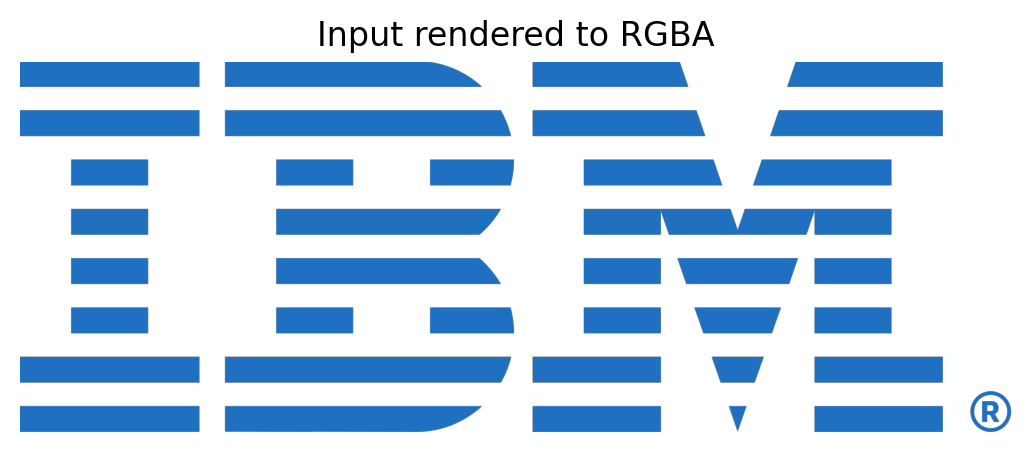

In [ ]:
# Colab cell: load (PNG) or rasterize (SVG) into an RGBA PIL Image

def load_rgba_image(path: str, raster_width_px: int) -> Image.Image:
    """Load a PNG directly, or rasterize an SVG into RGBA."""
    ext = os.path.splitext(path.lower())[1]
    if ext == ".svg":
        with open(path, "rb") as f:
            svg_bytes = f.read()
        png_bytes = cairosvg.svg2png(bytestring=svg_bytes, output_width=raster_width_px)
        img = Image.open(io.BytesIO(png_bytes)).convert("RGBA")
        return img

    # Default: treat as raster image (PNG recommended for transparency)
    img = Image.open(path).convert("RGBA")
    return img


img_rgba = load_rgba_image(input_path, CFG.raster_width_px)
print("RGBA image size (px):", img_rgba.size)

# Quick preview (no manual colors specified)
import matplotlib.pyplot as plt  # noqa: E402

plt.figure()
plt.title("Input rendered to RGBA")
plt.imshow(img_rgba)
plt.axis("off")
plt.show()


Contours found: 41


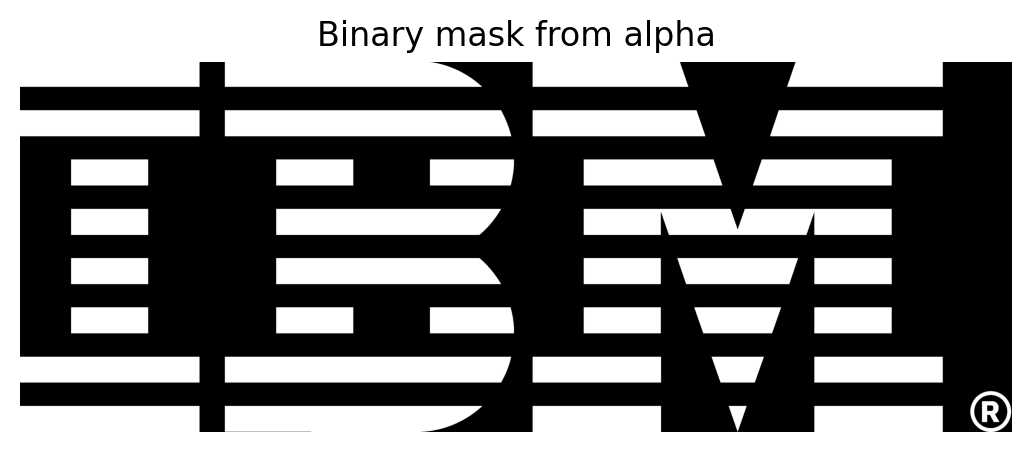

In [ ]:
# Colab cell: mask extraction + contour hierarchy

def rgba_to_mask(
    img: Image.Image,
    alpha_threshold: int,
    morph_close_px: int,
) -> np.ndarray:
    """Create a binary mask (uint8 0/255) from RGBA alpha channel."""
    arr = np.array(img, dtype=np.uint8)
    alpha = arr[:, :, 3]

    mask = (alpha >= np.uint8(alpha_threshold)).astype(np.uint8) * 255

    if morph_close_px and morph_close_px > 0:
        k = int(morph_close_px)
        kernel = np.ones((k, k), dtype=np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    return mask


mask_u8 = rgba_to_mask(img_rgba, CFG.alpha_threshold, CFG.morph_close_px)

# Retrieve outer contours + holes (CCOMP gives a clean 2-level structure)
contours, hierarchy = cv2.findContours(mask_u8, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
if hierarchy is None or len(contours) == 0:
    raise RuntimeError("No contours found. Try lowering alpha_threshold or increasing raster_width_px.")

hierarchy = hierarchy[0]  # shape: (N, 4) with [next, prev, child, parent]

print("Contours found:", len(contours))

# Preview mask
plt.figure()
plt.title("Binary mask from alpha")
plt.imshow(mask_u8, cmap="gray")
plt.axis("off")
plt.show()


Global pixel bounds:
  x_px: 0.0 to 3996.0 span: 3996.0
  y_px: 0.0 to 1492.0 span: 1492.0
Scale (mm/px): 0.00025025025025025025
Simplify epsilon (px): 0.0
Outer contour count: 39
Kept regions: 39


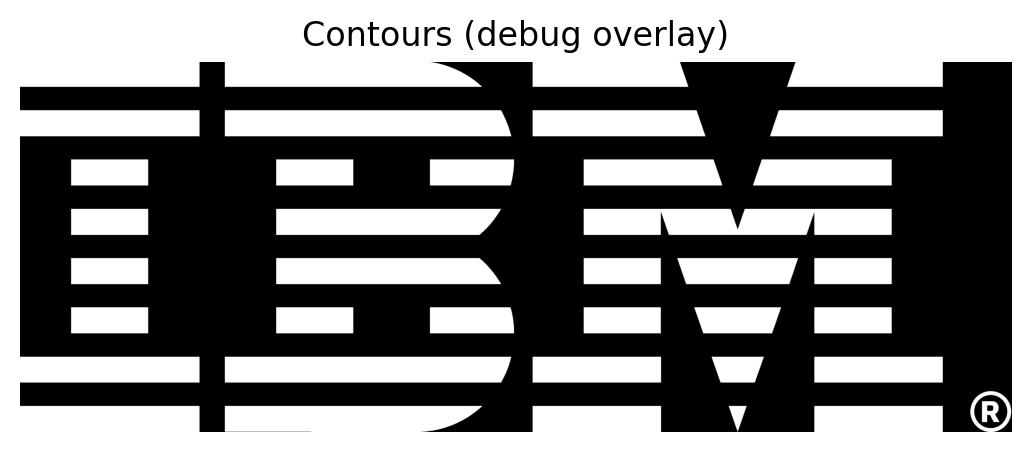

In [ ]:
# Colab cell: contour -> scaled polygons in mm

Point2D = Tuple[float, float]
Loop = List[Point2D]


def polygon_signed_area(points: Sequence[Point2D]) -> float:
    """Compute signed area; positive means counter-clockwise for (x,y) Cartesian."""
    if len(points) < 3:
        return 0.0
    s = 0.0
    for i in range(len(points)):
        x1, y1 = points[i]
        x2, y2 = points[(i + 1) % len(points)]
        s += (x1 * y2) - (x2 * y1)
    return 0.5 * s


def dedupe_consecutive(points: Sequence[Point2D], eps: float = 0.0) -> Loop:
    """Remove consecutive duplicate points (within eps)."""
    out: Loop = []
    for p in points:
        if not out:
            out.append(p)
            continue
        if abs(p[0] - out[-1][0]) <= eps and abs(p[1] - out[-1][1]) <= eps:
            continue
        out.append(p)
    # If last equals first, drop last (we will close implicitly)
    if len(out) >= 2 and abs(out[0][0] - out[-1][0]) <= eps and abs(out[0][1] - out[-1][1]) <= eps:
        out = out[:-1]
    return out


def contour_to_xy_px(cnt: np.ndarray) -> np.ndarray:
    """Flatten OpenCV contour shape (N,1,2) -> (N,2) in pixel coordinates."""
    return cnt.reshape(-1, 2)


# Compute global x-span for scaling
all_xy = np.vstack([contour_to_xy_px(c) for c in contours])
min_x_px = float(np.min(all_xy[:, 0]))
max_x_px = float(np.max(all_xy[:, 0]))
min_y_px = float(np.min(all_xy[:, 1]))
max_y_px = float(np.max(all_xy[:, 1]))

span_x_px = max_x_px - min_x_px
if span_x_px <= 0:
    raise RuntimeError("Degenerate X-span; cannot scale. Check input.")

scale_mm_per_px = CFG.target_width_mm / span_x_px
print("Global pixel bounds:")
print("  x_px:", min_x_px, "to", max_x_px, "span:", span_x_px)
print("  y_px:", min_y_px, "to", max_y_px, "span:", max_y_px - min_y_px)
print("Scale (mm/px):", scale_mm_per_px)

# Simplification tolerance: mm -> px
epsilon_px = 0.0
if CFG.simplify_epsilon_mm and CFG.simplify_epsilon_mm > 0.0:
    epsilon_px = float(CFG.simplify_epsilon_mm / scale_mm_per_px)
print("Simplify epsilon (px):", epsilon_px)


def px_to_mm(x_px: float, y_px: float) -> Point2D:
    """Convert pixels to mm, shifting to x>=0 and flipping y to be Cartesian-like."""
    x_mm = (x_px - min_x_px) * scale_mm_per_px
    y_mm = (max_y_px - y_px) * scale_mm_per_px  # flip y
    return (float(x_mm), float(y_mm))


# Build structure: list of (outer_loop, [hole_loops...])
regions: List[Tuple[Loop, List[Loop]]] = []

# Index contours by parent
children_by_parent: Dict[int, List[int]] = {}
for idx, h in enumerate(hierarchy):
    parent = int(h[3])
    if parent not in children_by_parent:
        children_by_parent[parent] = []
    children_by_parent[parent].append(idx)

# Outer contours have parent == -1
outer_indices = children_by_parent.get(-1, [])
print("Outer contour count:", len(outer_indices))


def contour_area_mm2(cnt: np.ndarray) -> float:
    """Area in mm^2, based on OpenCV contour area in px^2."""
    area_px2 = float(abs(cv2.contourArea(cnt)))
    return area_px2 * (scale_mm_per_px ** 2)


def contour_to_loop_mm(cnt: np.ndarray, want_ccw: bool) -> Loop:
    """Convert an OpenCV contour to a simplified, de-duplicated loop in mm."""
    cc = cnt
    if epsilon_px and epsilon_px > 0.0:
        cc = cv2.approxPolyDP(cnt, epsilon=epsilon_px, closed=True)

    xy = contour_to_xy_px(cc)
    pts_mm = [px_to_mm(float(x), float(y)) for x, y in xy]
    pts_mm = dedupe_consecutive(pts_mm, eps=0.0)

    if len(pts_mm) < 3:
        return []

    area = polygon_signed_area(pts_mm)
    is_ccw = area > 0.0
    if want_ccw != is_ccw:
        pts_mm = list(reversed(pts_mm))

    return pts_mm


min_area = float(CFG.min_area_mm2)
for oi in outer_indices:
    if contour_area_mm2(contours[oi]) < min_area:
        continue

    outer_loop = contour_to_loop_mm(contours[oi], want_ccw=True)
    if len(outer_loop) < 3:
        continue

    hole_loops: List[Loop] = []
    for hi in children_by_parent.get(oi, []):
        if contour_area_mm2(contours[hi]) < min_area:
            continue
        hole_loop = contour_to_loop_mm(contours[hi], want_ccw=False)
        if len(hole_loop) >= 3:
            hole_loops.append(hole_loop)

    regions.append((outer_loop, hole_loops))

print("Kept regions:", len(regions))

# Quick overlay preview in pixel space (contours) just to sanity-check
preview = cv2.cvtColor(mask_u8, cv2.COLOR_GRAY2BGR)
cv2.drawContours(preview, contours, -1, (255, 255, 255), 1)  # OpenCV color tuple; acceptable here for debug
plt.figure()
plt.title("Contours (debug overlay)")
plt.imshow(preview)
plt.axis("off")
plt.show()


In [ ]:
# Colab cell: generate .geo text

def format_geo_float(x: float) -> str:
    """Format floats deterministically for .geo output."""
    return f"{x:.12f}"


def emit_geo(
    regions: Sequence[Tuple[Loop, Sequence[Loop]]],
    cfg: MeshConfig,
    out_name: str,
) -> str:
    """Create a Gmsh .geo script from polygonal regions."""
    lines: List[str] = []
    lines.append(f"// {out_name}")
    lines.append("// Generated in Google Colab: SVG/PNG (alpha) -> contours -> .geo")
    lines.append("// Units: millimeters (mm)")
    lines.append('SetFactory("OpenCASCADE");')
    lines.append("")

    # User-facing knobs inside the .geo as plain assignments
    lines.append("// ---- user knobs ----")
    lines.append(f"make3D = {1 if cfg.make_3d else 0};")
    lines.append(f"thickness = {format_geo_float(cfg.thickness_mm)}; // mm")
    lines.append(f"extrudeLayers = {int(cfg.extrude_layers)};")
    lines.append("")
    lines.append(f"lcMin = {format_geo_float(cfg.edge_size_min_mm)}; // near-edge element size (mm)")
    lines.append(f"lcMax = {format_geo_float(cfg.edge_size_max_mm)}; // far-field element size (mm)")
    lines.append(f"distMin = {format_geo_float(cfg.edge_dist_min_mm)}; // mm")
    lines.append(f"distMax = {format_geo_float(cfg.edge_dist_max_mm)}; // mm")
    lines.append(f"distSampling = {int(cfg.distance_sampling)};")
    lines.append("")
    lines.append(f"enableBL = {1 if cfg.enable_boundary_layer_2d else 0}; // 2D boundary layer field (mainly CFD)")
    lines.append(f"blSize = {format_geo_float(cfg.bl_size_mm)};")
    lines.append(f"blRatio = {format_geo_float(cfg.bl_ratio)};")
    lines.append(f"blThickness = {format_geo_float(cfg.bl_thickness_mm)};")
    lines.append(f"blNbLayers = {int(cfg.bl_n_layers)};")
    lines.append(f"blQuads = {int(cfg.bl_quads)};")
    lines.append("")

    # Geometry emission
    p_id = 1
    l_id = 1
    cl_id = 1
    s_id = 1

    surface_ids: List[int] = []

    def emit_loop(loop: Loop) -> Tuple[List[int], List[int]]:
        """Emit points and lines for one closed loop; return (point_ids, line_ids)."""
        nonlocal p_id, l_id
        point_ids: List[int] = []
        for (x, y) in loop:
            lines.append(f"Point({p_id}) = {{{format_geo_float(x)}, {format_geo_float(y)}, 0.0, lcMin}};")
            point_ids.append(p_id)
            p_id += 1

        line_ids: List[int] = []
        n = len(point_ids)
        for i in range(n):
            a = point_ids[i]
            b = point_ids[(i + 1) % n]
            lines.append(f"Line({l_id}) = {{{a}, {b}}};")
            line_ids.append(l_id)
            l_id += 1

        return point_ids, line_ids

    lines.append("// ---- geometry ----")
    for outer, holes in regions:
        # Outer
        _, outer_lines = emit_loop(outer)
        lines.append(f"Curve Loop({cl_id}) = {{{', '.join(map(str, outer_lines))}}};")
        outer_cl = cl_id
        cl_id += 1

        hole_cls: List[int] = []
        for hole in holes:
            _, hole_lines = emit_loop(hole)
            lines.append(f"Curve Loop({cl_id}) = {{{', '.join(map(str, hole_lines))}}};")
            hole_cls.append(cl_id)
            cl_id += 1

        # Surface with holes
        all_cls = [outer_cl] + hole_cls
        lines.append(f"Plane Surface({s_id}) = {{{', '.join(map(str, all_cls))}}};")
        surface_ids.append(s_id)
        s_id += 1
        lines.append("")

    if not surface_ids:
        raise RuntimeError("No surfaces emitted; check contour extraction.")

    # Make an array for later loops
    lines.append("// Surfaces array")
    lines.append(f"surfaces[] = {{{', '.join(map(str, surface_ids))}}};")
    lines.append("")

    # Optional extrusion
    lines.append("// ---- optional 3D extrusion ----")
    lines.append("volumes[] = {};")
    lines.append("topSurfaces[] = {};")
    lines.append("If (make3D)")
    lines.append("  For i In {0:#surfaces[]-1}")
    lines.append("    out[] = Extrude {0, 0, thickness} {")
    lines.append("      Surface{surfaces[i]};")
    lines.append("      Layers{extrudeLayers};")
    lines.append("      Recombine;")
    lines.append("    };")
    # Documented: out[0]=top, out[1]=volume, out[2..]=laterals :contentReference[oaicite:4]{index=4}
    lines.append("    topSurfaces[] += {out[0]};")
    lines.append("    volumes[] += {out[1]};")
    lines.append("  EndFor")
    lines.append("EndIf")
    lines.append("")

    # Physical groups
    lines.append("// ---- physical groups ----")
    lines.append("If (make3D)")
    lines.append('  Physical Volume("pattern") = {volumes[]};')
    lines.append('  Physical Surface("pattern_bottom") = {surfaces[]};')
    lines.append('  Physical Surface("pattern_top") = {topSurfaces[]};')
    lines.append("Else")
    lines.append('  Physical Surface("pattern") = {surfaces[]};')
    lines.append("EndIf")
    lines.append("")

    # Mesh sizing: Distance + Threshold :contentReference[oaicite:5]{index=5}
    lines.append("// ---- mesh sizing: edge-refined field ----")
    lines.append("Mesh.MeshSizeFromPoints = 0;")
    lines.append("Mesh.MeshSizeFromCurvature = 0;")
    lines.append("Mesh.MeshSizeExtendFromBoundary = 0;")
    lines.append("")

    lines.append("// Boundary curves for distance computation")
    lines.append("curves[] = {};")
    lines.append("If (make3D)")
    lines.append("  curves[] = Boundary{ Volume{volumes[]}; };")
    lines.append("Else")
    lines.append("  curves[] = Boundary{ Surface{surfaces[]}; };")
    lines.append("EndIf")
    lines.append("")

    lines.append("Field[1] = Distance;")
    lines.append("Field[1].CurvesList = curves[];")
    lines.append("Field[1].Sampling = distSampling;")
    lines.append("")
    lines.append("Field[2] = Threshold;")
    lines.append("Field[2].InField = 1;")
    lines.append("Field[2].SizeMin = lcMin;")
    lines.append("Field[2].SizeMax = lcMax;")
    lines.append("Field[2].DistMin = distMin;")
    lines.append("Field[2].DistMax = distMax;")
    lines.append("")

    # Optional 2D boundary layer field (mostly for CFD, mesh in 2D then extrude)
    # Manual: BoundaryLayer field is 2D and uses CurvesList/Size/Ratio/Thickness/NbLayers/Quads :contentReference[oaicite:6]{index=6}
    lines.append("// ---- optional 2D boundary layer field (CFD-ish) ----")
    lines.append("If (enableBL)")
    lines.append("  Field[3] = BoundaryLayer;")
    lines.append("  Field[3].CurvesList = curves[];")
    lines.append("  Field[3].Size = blSize;")
    lines.append("  Field[3].Ratio = blRatio;")
    lines.append("  Field[3].Thickness = blThickness;")
    lines.append("  Field[3].NbLayers = blNbLayers;")
    lines.append("  Field[3].Quads = blQuads;")
    # Practical .geo activation is widely used as 'BoundaryLayer Field = 3;' in community scripts.
    # Gmsh manual documents the API setAsBoundaryLayer() but does not show the .geo keyword inline. :contentReference[oaicite:7]{index=7}
    lines.append("  // NOTE: In the API this corresponds to gmsh/model/mesh/field/setAsBoundaryLayer(tag).")
    lines.append("  // In many .geo workflows, the following line activates the BL constraint:")
    lines.append("  BoundaryLayer Field = 3;")
    lines.append("Else")
    lines.append("  Background Field = 2;")
    lines.append("EndIf")
    lines.append("")

    lines.append("// You can mesh from the CLI, for example:")
    lines.append("//   gmsh -2 this_file.geo")
    lines.append("//   gmsh -3 this_file.geo   (if make3D=1)")
    lines.append("")

    return "\n".join(lines)


base = os.path.splitext(os.path.basename(input_path))[0]
geo_name = f"{base}_to_gmsh_{CFG.target_width_mm:.6f}mm.geo"
geo_text = emit_geo(regions=regions, cfg=CFG, out_name=geo_name)

geo_path = os.path.join("/content", geo_name)
with open(geo_path, "w", encoding="utf-8") as f:
    f.write(geo_text)

print("Wrote .geo to:", geo_path)
print("First 60 lines of the .geo file:")
print("\n".join(geo_text.splitlines()[:60]))


Wrote .geo to: /content/IBM_logo_to_gmsh_1.000000mm.geo
First 60 lines of the .geo file:
// IBM_logo_to_gmsh_1.000000mm.geo
// Generated in Google Colab: SVG/PNG (alpha) -> contours -> .geo
// Units: millimeters (mm)
SetFactory("OpenCASCADE");

// ---- user knobs ----
make3D = 0;
thickness = 0.050000000000; // mm
extrudeLayers = 1;

lcMin = 0.002500000000; // near-edge element size (mm)
lcMax = 0.014285714286; // far-field element size (mm)
distMin = 0.003333333333; // mm
distMax = 0.028571428571; // mm
distSampling = 150;

enableBL = 0; // 2D boundary layer field (mainly CFD)
blSize = 0.001250000000;
blRatio = 1.200000000000;
blThickness = 0.012500000000;
blNbLayers = 10;
blQuads = 1;

// ---- geometry ----
Point(1) = {0.801801801802, 0.026026026026, 0.0, lcMin};
Point(2) = {0.801551551552, 0.025775775776, 0.0, lcMin};
Point(3) = {0.801551551552, 0.000000000000, 0.0, lcMin};
Point(4) = {0.930930930931, 0.000000000000, 0.0, lcMin};
Point(5) = {0.930930930931, 0.026026026026, 0.0, lcMin

In [ ]:
# Colab cell: download result
from google.colab import files  # pylint: disable=import-error

files.download(geo_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Colab cell (optional): install gmsh and generate a .msh directly

!apt-get -qq update
!apt-get -qq install -y gmsh

# Mesh 2D surfaces (-2) or 3D volumes (-3)
mesh_dim_flag = "-3" if CFG.make_3d else "-2"
msh_path = geo_path.replace(".geo", ".msh")

!gmsh {mesh_dim_flag} "{geo_path}" -o "{msh_path}"

print("Wrote mesh:", msh_path)
from google.colab import files  # pylint: disable=import-error
files.download(msh_path)

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libalglib3.18:amd64.
(Reading database ... 117528 files and directories currently installed.)
Preparing to unpack .../00-libalglib3.18_3.18.0-1_amd64.deb ...
Unpacking libalglib3.18:amd64 (3.18.0-1) ...
Selecting previously unselected package libfltk1.3:amd64.
Preparing to unpack .../01-libfltk1.3_1.3.8-4_amd64.deb ...
Unpacking libfltk1.3:amd64 (1.3.8-4) ...
Selecting previously unselected package libfltk-gl1.3:amd64.
Preparing to unpack .../02-libfltk-gl1.3_1.3.8-4_amd64.deb ...
Unpacking libfltk-gl1.3:amd64 (1.3.8-4) ...
Selecting previously unselected package libfltk-images1.3:amd64.
Preparing to unpack .../03-libfltk-images1.3_1.3.8-4_amd64.deb ...
Unpacking libfltk-images1.3:amd64 (1.3.8-4) ...
Selecting previously unselected package libgl2ps1.4.
Preparin

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>